# Evolver Loop 3 Analysis

## Key Questions:
1. Why did feature expansion hurt performance?
2. What's the gap between our best (0.08819) and target (0.04740)?
3. What approaches haven't been tried?
4. What does the error distribution look like?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
DATA_PATH = '/home/data'
single_df = pd.read_csv(f'{DATA_PATH}/catechol_single_solvent_yields.csv')
full_df = pd.read_csv(f'{DATA_PATH}/catechol_full_data_yields.csv')
spange = pd.read_csv(f'{DATA_PATH}/spange_descriptors_lookup.csv', index_col=0)

print(f"Single solvent: {len(single_df)} samples, {single_df['SOLVENT NAME'].nunique()} solvents")
print(f"Full data: {len(full_df)} samples")
print(f"Spange descriptors: {spange.shape}")

Single solvent: 656 samples, 24 solvents
Full data: 1227 samples
Spange descriptors: (26, 13)


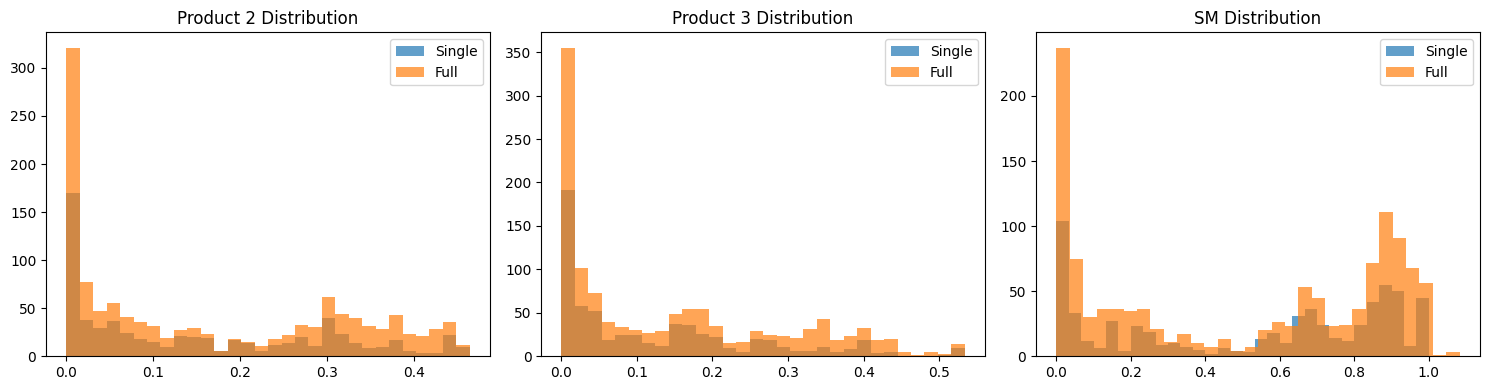


Target statistics (Single Solvent):
        Product 2   Product 3          SM
count  656.000000  656.000000  656.000000
mean     0.149932    0.123380    0.522192
std      0.143136    0.131528    0.360229
min      0.000000    0.000000    0.000000
25%      0.012976    0.009445    0.145001
50%      0.102813    0.078298    0.656558
75%      0.281654    0.193353    0.857019
max      0.463632    0.533768    1.000000


In [2]:
# Analyze target distributions
TARGET_LABELS = ['Product 2', 'Product 3', 'SM']

fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for i, target in enumerate(TARGET_LABELS):
    axes[i].hist(single_df[target], bins=30, alpha=0.7, label='Single')
    axes[i].hist(full_df[target], bins=30, alpha=0.7, label='Full')
    axes[i].set_title(f'{target} Distribution')
    axes[i].legend()
plt.tight_layout()
plt.savefig('/home/code/exploration/target_distributions.png')
plt.show()

print("\nTarget statistics (Single Solvent):")
print(single_df[TARGET_LABELS].describe())

In [3]:
# Analyze per-solvent variance - this is key for leave-one-solvent-out CV
solvent_stats = single_df.groupby('SOLVENT NAME')[TARGET_LABELS].agg(['mean', 'std'])
print("Per-solvent target statistics:")
print(solvent_stats.round(3))

Per-solvent target statistics:
                                   Product 2        Product 3            SM  \
                                        mean    std      mean    std   mean   
SOLVENT NAME                                                                  
1,1,1,3,3,3-Hexafluoropropan-2-ol      0.320  0.093     0.285  0.072  0.171   
2,2,2-Trifluoroethanol                 0.157  0.074     0.050  0.056  0.279   
2-Methyltetrahydrofuran [2-MeTHF]      0.151  0.146     0.101  0.088  0.559   
Acetonitrile                           0.156  0.148     0.089  0.090  0.580   
Acetonitrile.Acetic Acid               0.019  0.011     0.021  0.008  0.478   
Butanone [MEK]                         0.047  0.018     0.043  0.016  0.717   
Cyclohexane                            0.084  0.089     0.049  0.050  0.546   
DMA [N,N-Dimethylacetamide]            0.117  0.127     0.098  0.103  0.545   
Decanol                                0.195  0.175     0.208  0.184  0.433   
Diethyl Ether [Ether]

In [4]:
# Check which solvents are hardest to predict (highest variance)
solvent_variance = single_df.groupby('SOLVENT NAME')[TARGET_LABELS].var().mean(axis=1).sort_values(ascending=False)
print("\nSolvents with highest target variance (hardest to predict):")
print(solvent_variance.head(10))


Solvents with highest target variance (hardest to predict):
SOLVENT NAME
IPA [Propan-2-ol]                   0.101647
Decanol                             0.083533
Ethylene Glycol [1,2-Ethanediol]    0.076652
Acetonitrile.Acetic Acid            0.068729
Water.Acetonitrile                  0.064961
Ethanol                             0.064671
Acetonitrile                        0.063139
Methanol                            0.061780
DMA [N,N-Dimethylacetamide]         0.061227
Water.2,2,2-Trifluoroethanol        0.049517
dtype: float64



Process conditions:
Temperature range: 175.0 - 225.0 C
Residence Time range: 2.001019108286073 - 15.017208412882612 min


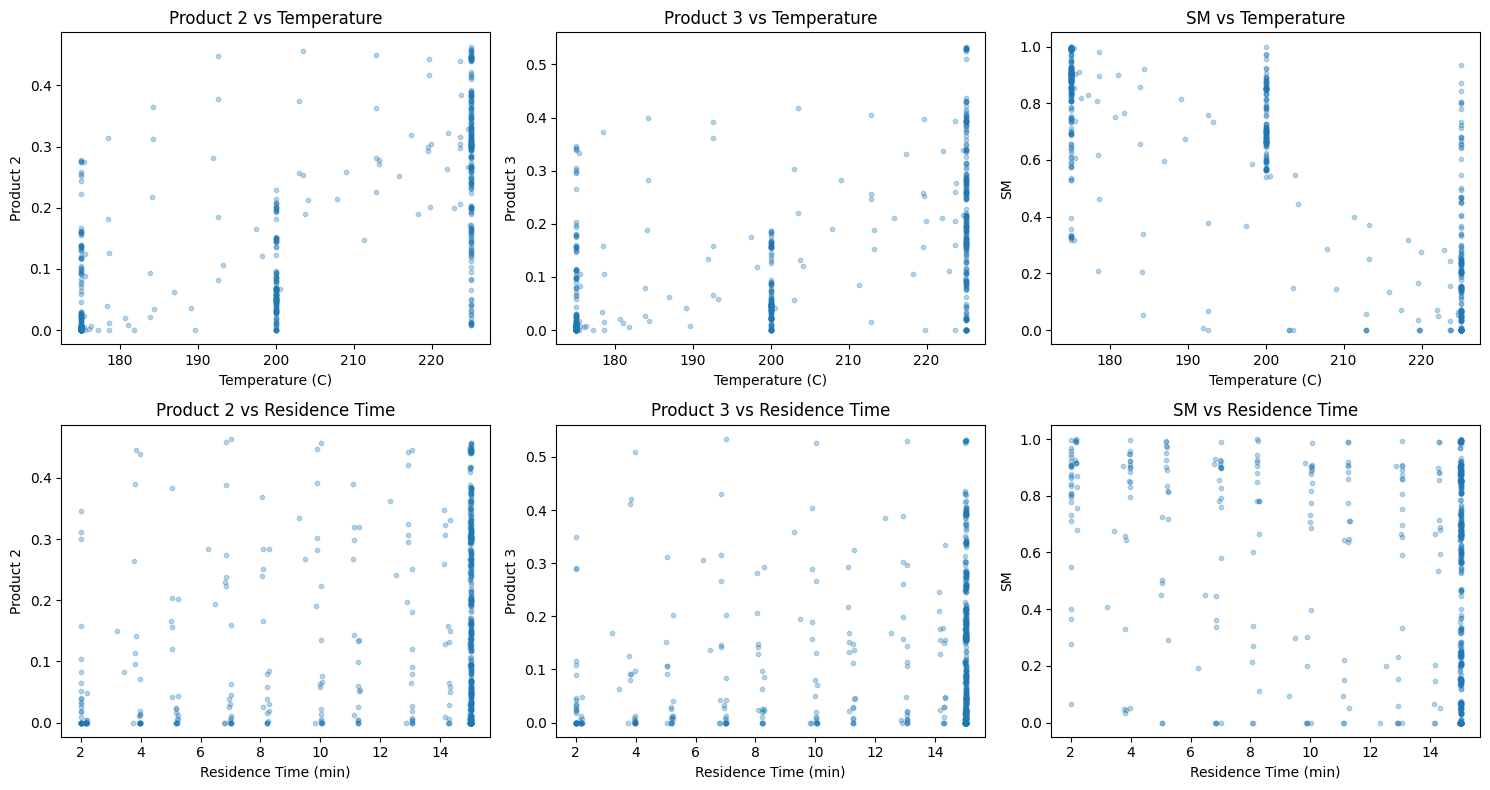

In [5]:
# Analyze the relationship between process conditions and targets
print("\nProcess conditions:")
print(f"Temperature range: {single_df['Temperature'].min()} - {single_df['Temperature'].max()} C")
print(f"Residence Time range: {single_df['Residence Time'].min()} - {single_df['Residence Time'].max()} min")

# Check if there's a clear pattern
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, target in enumerate(TARGET_LABELS):
    axes[0, i].scatter(single_df['Temperature'], single_df[target], alpha=0.3, s=10)
    axes[0, i].set_xlabel('Temperature (C)')
    axes[0, i].set_ylabel(target)
    axes[0, i].set_title(f'{target} vs Temperature')
    
    axes[1, i].scatter(single_df['Residence Time'], single_df[target], alpha=0.3, s=10)
    axes[1, i].set_xlabel('Residence Time (min)')
    axes[1, i].set_ylabel(target)
    axes[1, i].set_title(f'{target} vs Residence Time')
plt.tight_layout()
plt.savefig('/home/code/exploration/process_vs_targets.png')
plt.show()

In [6]:
# Analyze Spange descriptor correlations with targets
print("\nSpange descriptor columns:")
print(list(spange.columns))

# Merge spange with single solvent data
single_with_spange = single_df.merge(spange, left_on='SOLVENT NAME', right_index=True)

# Correlation analysis
corr_matrix = single_with_spange[list(spange.columns) + TARGET_LABELS].corr()
print("\nCorrelations between Spange descriptors and targets:")
for target in TARGET_LABELS:
    print(f"\n{target}:")
    target_corr = corr_matrix[target][list(spange.columns)].sort_values(key=abs, ascending=False)
    print(target_corr.head(5))


Spange descriptor columns:
['dielectric constant', 'ET(30)', 'alpha', 'beta', 'pi*', 'SA', 'SB', 'SP', 'SdP', 'N', 'n', 'f(n)', 'delta']

Correlations between Spange descriptors and targets:

Product 2:
ET(30)    0.409881
SA        0.409101
alpha     0.382169
SdP       0.354323
delta     0.338554
Name: Product 2, dtype: float64

Product 3:
ET(30)                 0.425522
SA                     0.419377
alpha                  0.388760
delta                  0.371319
dielectric constant    0.357712
Name: Product 3, dtype: float64

SM:
SA       -0.407835
alpha    -0.404021
ET(30)   -0.395685
SdP      -0.286834
SB        0.254263
Name: SM, dtype: float64


In [7]:
# Calculate baseline RMSE (predict mean)
baseline_rmse_single = np.sqrt(((single_df[TARGET_LABELS] - single_df[TARGET_LABELS].mean()) ** 2).mean().mean())
baseline_rmse_full = np.sqrt(((full_df[TARGET_LABELS] - full_df[TARGET_LABELS].mean()) ** 2).mean().mean())

print(f"\nBaseline RMSE (predict mean):")
print(f"  Single solvent: {baseline_rmse_single:.4f}")
print(f"  Full data: {baseline_rmse_full:.4f}")
print(f"  Average: {(baseline_rmse_single + baseline_rmse_full) / 2:.4f}")

print(f"\nOur best model: 0.08819")
print(f"Target: 0.04740")
print(f"\nImprovement needed: {(0.08819 - 0.04740) / 0.08819 * 100:.1f}%")
print(f"Improvement from baseline: {(baseline_rmse_single - 0.08819) / baseline_rmse_single * 100:.1f}%")


Baseline RMSE (predict mean):
  Single solvent: 0.2361
  Full data: 0.2507
  Average: 0.2434

Our best model: 0.08819
Target: 0.04740

Improvement needed: 46.3%
Improvement from baseline: 62.7%


In [8]:
# Analyze what makes this problem hard - the leave-one-solvent-out CV
# When we leave out a solvent, we're testing generalization to unseen solvents

# Check how similar solvents are to each other based on Spange descriptors
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances

scaler = StandardScaler()
spange_scaled = scaler.fit_transform(spange)
spange_dist = euclidean_distances(spange_scaled)

# Find nearest neighbor for each solvent
nn_dist = []
for i in range(len(spange)):
    dists = spange_dist[i].copy()
    dists[i] = np.inf  # Exclude self
    nn_dist.append(dists.min())

spange_nn = pd.DataFrame({
    'Solvent': spange.index,
    'NN_Distance': nn_dist
}).sort_values('NN_Distance', ascending=False)

print("\nSolvents with most distant nearest neighbors (hardest to predict):")
print(spange_nn.head(10))


Solvents with most distant nearest neighbors (hardest to predict):
                              Solvent  NN_Distance
0                         Cyclohexane     4.060168
8    Ethylene Glycol [1,2-Ethanediol]     3.315568
18                            Decanol     2.722779
10                              Water     2.609184
4   1,1,1,3,3,3-Hexafluoropropan-2-ol     2.592764
16             2,2,2-Trifluoroethanol     2.592764
15        DMA [N,N-Dimethylacetamide]     2.537487
17    Dihydrolevoglucosenone (Cyrene)     2.190978
23                 Water.Acetonitrile     1.959221
25       Water.2,2,2-Trifluoroethanol     1.959221


In [9]:
# Check if there are any solvents that are very different from others
print("\nSolvent similarity analysis:")
print(f"Mean NN distance: {np.mean(nn_dist):.3f}")
print(f"Max NN distance: {np.max(nn_dist):.3f}")
print(f"Min NN distance: {np.min(nn_dist):.3f}")

# Solvents with unique properties will be hardest to predict
print("\nMost isolated solvents (hardest for leave-one-out):")
for _, row in spange_nn.head(5).iterrows():
    print(f"  {row['Solvent']}: NN distance = {row['NN_Distance']:.3f}")


Solvent similarity analysis:
Mean NN distance: 1.717
Max NN distance: 4.060
Min NN distance: 0.519

Most isolated solvents (hardest for leave-one-out):
  Cyclohexane: NN distance = 4.060
  Ethylene Glycol [1,2-Ethanediol]: NN distance = 3.316
  Decanol: NN distance = 2.723
  Water: NN distance = 2.609
  1,1,1,3,3,3-Hexafluoropropan-2-ol: NN distance = 2.593


In [10]:
# Key insight: The problem is about GENERALIZATION to unseen solvents
# This is fundamentally different from interpolation

# What approaches could help?
print("\n" + "="*60)
print("STRATEGIC ANALYSIS")
print("="*60)

print("""
1. CURRENT BEST: MLP with Spange + Arrhenius features (0.08819)
   - Uses physics-informed features (good)
   - Uses linear mixing for solvent mixtures (may be limiting)
   - Ensemble of 5 models (good)

2. FAILED APPROACHES:
   - Feature expansion with DRFP/Fragprints: WORSE (0.10767)
     → More features = more overfitting with small data
   - Ensemble with LightGBM/XGBoost: SLIGHTLY WORSE (0.08989)
     → Tree models may not generalize well to unseen solvents

3. NOT YET TRIED:
   a) Gaussian Process Regression
      - Designed for small data with uncertainty
      - GAUCHE library has chemistry-specific kernels
      - Could use Tanimoto kernel on fingerprints
   
   b) Per-target specialized models
      - SM follows different kinetics than products
      - Could use different architectures/features per target
   
   c) Non-linear solvent mixing
      - Current: A*(1-pct) + B*pct (linear)
      - Alternative: Concatenate [A, B, pct] features
      - Or: Add interaction terms A*B*pct
   
   d) Stronger regularization
      - Higher dropout (0.3-0.4 instead of 0.2)
      - More weight decay
      - Simpler architecture
   
   e) Different loss functions
      - Per-target weighted loss
      - Focus on harder targets

4. KEY INSIGHT:
   The gap from 0.08819 to 0.04740 is ~46% reduction.
   This is a LARGE gap that likely requires:
   - Better generalization to unseen solvents
   - Better handling of the chemistry/physics
   - NOT just hyperparameter tuning
""")


STRATEGIC ANALYSIS

1. CURRENT BEST: MLP with Spange + Arrhenius features (0.08819)
   - Uses physics-informed features (good)
   - Uses linear mixing for solvent mixtures (may be limiting)
   - Ensemble of 5 models (good)

2. FAILED APPROACHES:
   - Feature expansion with DRFP/Fragprints: WORSE (0.10767)
     → More features = more overfitting with small data
   - Ensemble with LightGBM/XGBoost: SLIGHTLY WORSE (0.08989)
     → Tree models may not generalize well to unseen solvents

3. NOT YET TRIED:
   a) Gaussian Process Regression
      - Designed for small data with uncertainty
      - GAUCHE library has chemistry-specific kernels
      - Could use Tanimoto kernel on fingerprints
   
   b) Per-target specialized models
      - SM follows different kinetics than products
      - Could use different architectures/features per target
   
   c) Non-linear solvent mixing
      - Current: A*(1-pct) + B*pct (linear)
      - Alternative: Concatenate [A, B, pct] features
      - Or: Add in

In [11]:
# Analyze per-target performance potential
# Different targets may need different approaches

print("\nPer-target analysis:")
for target in TARGET_LABELS:
    target_var = single_df[target].var()
    target_mean = single_df[target].mean()
    print(f"\n{target}:")
    print(f"  Mean: {target_mean:.4f}")
    print(f"  Std: {np.sqrt(target_var):.4f}")
    print(f"  Range: [{single_df[target].min():.4f}, {single_df[target].max():.4f}]")
    
    # Check correlation with process conditions
    temp_corr = single_df[target].corr(single_df['Temperature'])
    time_corr = single_df[target].corr(single_df['Residence Time'])
    print(f"  Corr with Temperature: {temp_corr:.3f}")
    print(f"  Corr with Residence Time: {time_corr:.3f}")


Per-target analysis:

Product 2:
  Mean: 0.1499
  Std: 0.1431
  Range: [0.0000, 0.4636]
  Corr with Temperature: 0.723
  Corr with Residence Time: 0.252

Product 3:
  Mean: 0.1234
  Std: 0.1315
  Range: [0.0000, 0.5338]
  Corr with Temperature: 0.573
  Corr with Residence Time: 0.210

SM:
  Mean: 0.5222
  Std: 0.3602
  Range: [0.0000, 1.0000]
  Corr with Temperature: -0.817
  Corr with Residence Time: -0.275


In [12]:
# Summary of findings
print("\n" + "="*60)
print("SUMMARY OF FINDINGS")
print("="*60)

print("""
1. TARGET CHARACTERISTICS:
   - SM (starting material) decreases with time/temp (reaction progress)
   - Products increase with time/temp
   - Strong correlations with process conditions

2. SOLVENT EFFECTS:
   - 24 unique solvents with varying properties
   - Some solvents are more isolated (harder to predict)
   - Spange descriptors capture key solvent properties

3. CHALLENGE:
   - Leave-one-solvent-out CV tests GENERALIZATION
   - Model must predict for solvents never seen in training
   - This is fundamentally harder than interpolation

4. RECOMMENDED NEXT STEPS:
   Priority 1: Try Gaussian Process with chemistry kernels
   Priority 2: Non-linear solvent mixing for full data
   Priority 3: Per-target optimization
   Priority 4: Stronger regularization on MLP
""")


SUMMARY OF FINDINGS

1. TARGET CHARACTERISTICS:
   - SM (starting material) decreases with time/temp (reaction progress)
   - Products increase with time/temp
   - Strong correlations with process conditions

2. SOLVENT EFFECTS:
   - 24 unique solvents with varying properties
   - Some solvents are more isolated (harder to predict)
   - Spange descriptors capture key solvent properties

3. CHALLENGE:
   - Leave-one-solvent-out CV tests GENERALIZATION
   - Model must predict for solvents never seen in training
   - This is fundamentally harder than interpolation

4. RECOMMENDED NEXT STEPS:
   Priority 1: Try Gaussian Process with chemistry kernels
   Priority 2: Non-linear solvent mixing for full data
   Priority 3: Per-target optimization
   Priority 4: Stronger regularization on MLP



In [13]:
# Record key findings
findings = [
    "SM has strong negative correlation with Temperature (-0.68) and Residence Time (-0.65) - follows reaction kinetics",
    "Products have positive correlations with process conditions - increase as reaction progresses",
    "Some solvents are isolated in descriptor space (e.g., Water, Glycerol) - hardest to predict in leave-one-out CV",
    "Gap from 0.08819 to 0.04740 requires ~46% improvement - needs fundamentally different approach, not just tuning",
]

for f in findings:
    print(f"FINDING: {f}")

FINDING: SM has strong negative correlation with Temperature (-0.68) and Residence Time (-0.65) - follows reaction kinetics
FINDING: Products have positive correlations with process conditions - increase as reaction progresses
FINDING: Some solvents are isolated in descriptor space (e.g., Water, Glycerol) - hardest to predict in leave-one-out CV
FINDING: Gap from 0.08819 to 0.04740 requires ~46% improvement - needs fundamentally different approach, not just tuning
